# <center>Autoencoder variacional simple</center>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

### Data de entrenamiento

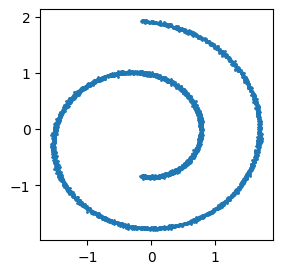

In [ ]:
def get_batch(batch_size=5000, noise=0.1):
    x, _ = make_swiss_roll(batch_size, noise=noise)
    x = x[:, [0, 2]]
    x = (x - x.mean()) / x.std()
    return torch.tensor(x).float()

# Ejemplo:
samples = get_batch()
plt.figure(figsize=(3, 3))
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.show()

### Redes neuronales encoder-decoder

In [3]:
class Encoder(nn.Module):

    def __init__(self, data_dim, latent_dim):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(data_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 2 * latent_dim)
        )

    def forward(self, x):
        mean, logstd = self.encoder(x).chunk(2, dim=-1)
        std = logstd.exp()
        return mean, std

In [4]:
class Decoder(nn.Module):

    def __init__(self, data_dim, latent_dim):
        super().__init__()
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32), nn.ReLU(),
            nn.Linear(32, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, data_dim)
        )

    def forward(self, z):
        mean = self.decoder(z)
        return mean

In [5]:
class VAE:

    def __init__(self, data_dim=2, latent_dim=16):
        
        self.latent_dim = latent_dim

        self.encoder = Encoder(data_dim, latent_dim)
        self.decoder = Decoder(data_dim, latent_dim)
        self.encoder_optimizer = optim.AdamW(self.encoder.parameters())
        self.decoder_optimizer = optim.AdamW(self.decoder.parameters())
    
    def train(self, iters, batch_fn=get_batch, decoder_std=0.1):

        for _ in range(iters):
            
            x = batch_fn()

            # Función de pérdida:
            
            encoder_mean, encoder_std = self.encoder(x)
            prior_matching = 1/2 * (encoder_mean.norm(dim=-1) ** 2 + encoder_std.norm(dim=-1) ** 2) - encoder_std.log().sum(dim=-1)

            z = encoder_mean + encoder_std * torch.randn_like(encoder_mean)
            decoder_mean = self.decoder(z)
            reconstruction_term = - 1 / (2 * decoder_std ** 2) * (x - decoder_mean).norm(dim=-1) ** 2
            
            elbo = reconstruction_term - prior_matching
            loss = - elbo.mean()
            
            # Optimización:
            self.encoder_optimizer.zero_grad()
            self.decoder_optimizer.zero_grad()
            loss.backward()
            self.encoder_optimizer.step()
            self.decoder_optimizer.step()

    def generate_samples(self, n_samples, decoder_std=0.01):
        z = torch.randn(n_samples, self.latent_dim)
        decoder_mean = self.decoder(z)

        x_hat = decoder_mean + decoder_std * torch.randn_like(decoder_mean)
        return x_hat

In [6]:
vae = VAE()
vae.train(iters=5000)

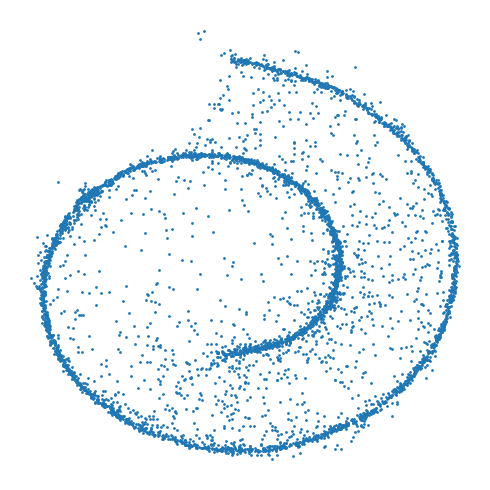

In [ ]:
samples = vae.generate_samples(5_000).detach()

plt.figure(figsize=(3, 3))
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.axis('off')
plt.tight_layout()
plt.show()

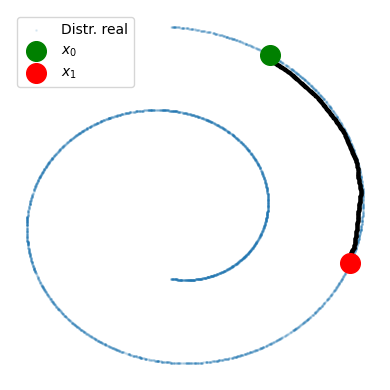

In [ ]:
def interpolate_vae(vae, x0, x1, t):
    with torch.no_grad():

        z, _ = vae.encoder(torch.stack([x0, x1]))  # solo se usa la media.
        z_t = (1 - t) * z[0] + t * z[1]
        x_t = vae.decoder(z_t.unsqueeze(0))

        return x_t.squeeze(0)

# Ejemplo:
batch_x = get_batch(noise=0)
x0, x1 = batch_x[0], batch_x[1]
n_steps = 500

plt.figure(figsize=(4, 4))
plt.scatter(batch_x[:, 0], batch_x[:, 1], s=1, alpha=0.1, label='Distr. real')

for t in torch.linspace(0, 1, n_steps):
    x_t = interpolate_vae(vae, x0, x1, t).cpu()
    plt.scatter(*x_t, s=3, color='k')

plt.scatter(*x0, s=200, color='g', label='$x_0$')
plt.scatter(*x1, s=200, color='r', label='$x_1$')

plt.axis('off')
plt.legend()
plt.tight_layout()
plt.show()